Normally I would write a organized module for modeling, but for time and demonstration purposes (both EDA and development flow), a Jupyter notebook is easier. 

After reviewing the data, I would have taken an ML-based approach rather than DL, using feature engineering based on text lengths, unique word counts, missing values etc. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial
from contextlib import contextmanager
from collections import ChainMap
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
import pickle
import hdbscan
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JackMiller\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JackMiller\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv(r"../Downloads/data.csv")
df = df.fillna('')
df = df.astype(str)

In [5]:
df2 = df.copy()

## Preprocess

In [6]:
class TextPreprocessor:
    def __init__(self, text):
        self.text = text
        self.stemmer = SnowballStemmer('english')
        self.lemmatizer = WordNetLemmatizer()
    
    def run_preprocessing(self):
        text = self.text.apply(self.preprocess)
        text = text.apply(self.remove_stopwords)
        # text = text.apply(self.stemming)
        text = text.apply(self.lemmatizing)
        return text
    
    @staticmethod
    def preprocess(text):
        text = text.lower() 
        text=text.strip()  
        text=re.compile('<.*?>').sub('', text) 
        text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) 
        text = re.sub('\s+', ' ', text) 
        text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] 
        text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
        text = re.sub(r'\d',' ',text) 
        text = re.sub(r'\s+',' ',text) 
        return text
    
    @staticmethod
    def remove_stopwords(text):
        chars = [i for i in text.split() if i not in stopwords.words('english')]
        return ' '.join(chars)
    
    def stemming(self, text):
        chars = [self.stemmer.stem(i) for i in word_tokenize(text)]
        return " ".join(chars)
    
    def lemmatizing(self, text):
        lemmatizer = self.lemmatizer
        words = nltk.word_tokenize(text)
        chars = [lemmatizer.lemmatize(word) for word in words]

        return " ".join(chars)

In [7]:
df2['clean_categories'] = TextPreprocessor(df['categories']).run_preprocessing()
df2['clean_reviews'] = TextPreprocessor(df['reviews']).run_preprocessing()

label_mapping = {'722511': 1, '722513': 0}
df2['is_full_service'] = df['label'].map(label_mapping)
df2['photo_labels_clean'] = df['photo_labels_high_confidence'].apply(lambda x: list(set(x.split(' '))))
df2['clean_desc'] = TextPreprocessor(df['description']).run_preprocessing()

# EDA

In [8]:
# Class distribution
df2['label'].value_counts()

722511    650
722513    650
Name: label, dtype: int64

In [9]:
print("Null website articles for full service:", len(df2[(df2['is_full_service'] == 1) & (df2['website_articles'] == '')])/len(df2))

Null website articles for full service: 0.14692307692307693


In [10]:
print("Null website articles for partial service:", len(df2[(df2['is_full_service'] == 0) & (df2['website_articles'] == '')])/len(df2))

Null website articles for partial service: 0.23153846153846153


In [11]:
len(df2[(df2['is_full_service'] == 1) & (df2['photo_labels_high_confidence'] == '')])/len(df2)

0.06

In [12]:
len(df2[(df2['is_full_service'] == 0) & (df2['photo_labels_high_confidence'] == '')])/len(df2)

0.17076923076923076

<AxesSubplot:xlabel='clean_categories', ylabel='Count'>

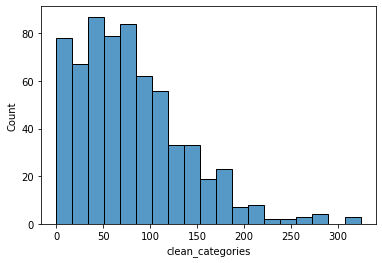

In [14]:
sns.histplot(df2[df2['is_full_service'] == 1]['clean_categories'].astype('str').apply(lambda x: len(x)))

<AxesSubplot:xlabel='clean_categories', ylabel='Count'>

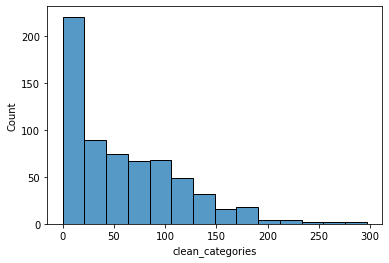

In [15]:
sns.histplot(df2[df2['is_full_service'] == 0]['clean_categories'].astype('str').apply(lambda x: len(x)))

<AxesSubplot:xlabel='clean_reviews', ylabel='Count'>

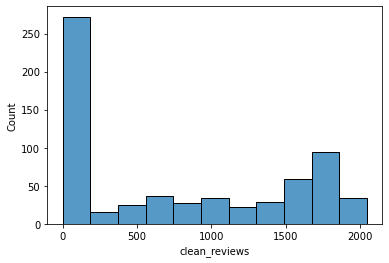

In [16]:
sns.histplot(df2[df2['is_full_service'] == 0]['clean_reviews'].astype('str').apply(lambda x: len(x)))

<AxesSubplot:xlabel='clean_reviews', ylabel='Count'>

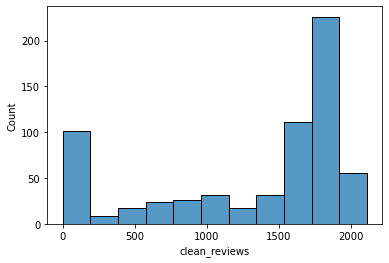

In [17]:
sns.histplot(df2[df2['is_full_service'] == 1]['clean_reviews'].astype('str').apply(lambda x: len(x)))

## N Grams

In [18]:
number=20

In [19]:
# bigram
no_fs_rev = df2[df2['is_full_service'] == 0]['clean_reviews']
vec =CountVectorizer(ngram_range=(2, 2)).fit(no_fs_rev) 
bag_of_words = vec.transform(no_fs_rev)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

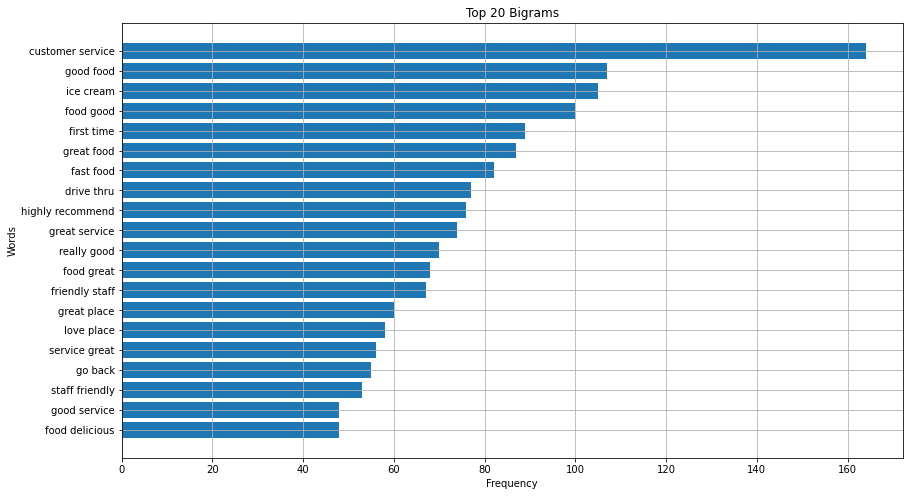

In [20]:
common_words = words_freq[:number]
dft3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(dft3["words"][::-1], dft3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top 20 Bigrams")
plt.grid(True)

In [21]:
# bigram
fs_rev = df2[df2['is_full_service'] == 1]['clean_reviews']
vec =CountVectorizer(ngram_range=(2, 2)).fit(fs_rev) 
bag_of_words = vec.transform(fs_rev)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

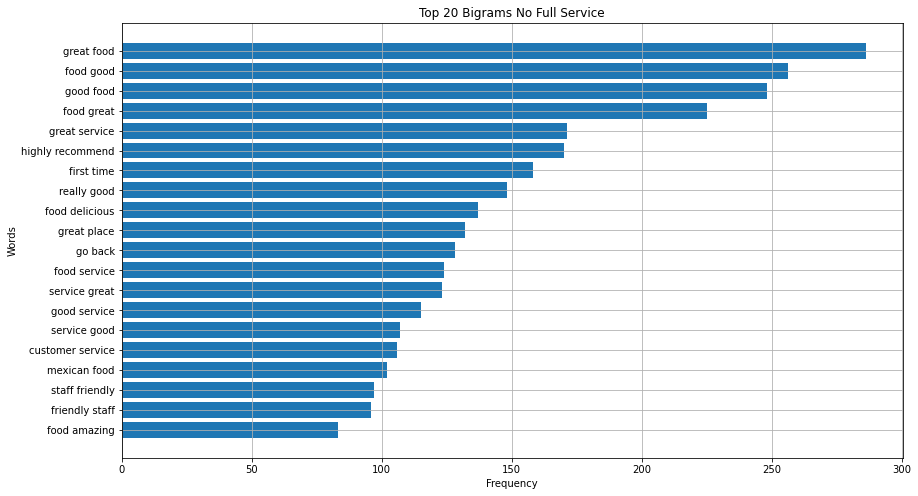

In [22]:
common_words = words_freq[:number]
dft3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(dft3["words"][::-1], dft3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top 20 Bigrams No Full Service")
plt.grid(True)

In [24]:
# trigram
fs_rev = df2[df2['is_full_service'] == 1]['clean_reviews']
vec = CountVectorizer(ngram_range=(3, 3)).fit(fs_rev) 
bag_of_words = vec.transform(fs_rev)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

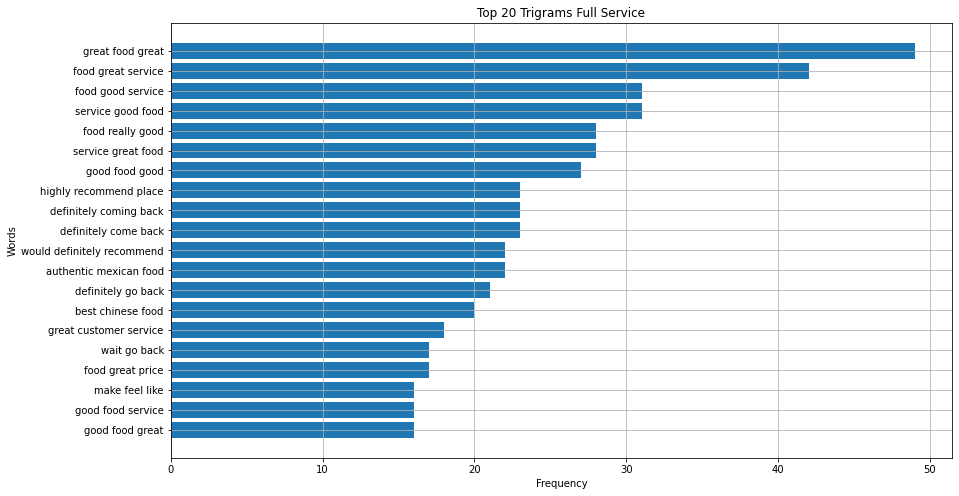

In [25]:
common_words = words_freq[:number]
dft3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(dft3["words"][::-1], dft3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top 20 Trigrams Full Service")
plt.grid(True)

---------

## Create Input Dataframe

In [26]:
modeling_df = pd.DataFrame()

In [27]:
label_mapping = {'722511': 1, '722513': 0}
modeling_df['is_full_service'] = df['label'].map(label_mapping)
modeling_df['photo_labels'] = df['photo_labels_high_confidence'].apply(lambda x: list(set(x.split(' '))))

In [28]:
features = ['categories', 'description', 'website_articles', 'reviews', 'website_text_concatenation', 'tabular_company_about']

In [ ]:
for feature in features:
    print(f"working on: {feature}")
    modeling_df[feature] = TextPreprocessor(df[feature]).run_preprocessing()

In [ ]:
modeling_df['photo_labels'] = modeling_df['photo_labels'].apply(lambda x: ', '.join(map(str, x)))

In [ ]:
modeling_df.to_csv('modeling_df.csv')

In [29]:
modeling_df = pd.read_csv('modeling_df.csv')

## Create embeddings

In [30]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def create_and_pool_glove(words: list, model):
    [model[word] for word in input_words if word in model.wv]
    

def apply_word_embedding(lists_of_words, model, pooling_method='mean', target_shape =(100,)):
    """
    GloVe word embeddings are D=100, and the BERT sentence embeddings are 384. In order to create feature embeddings of the same length,
    the GloVe embeddings are padded with 284 zeros to reach the same length as the sentence embeddings. 
    """
    embeddings = []

    for word_list in lists_of_words:
        word_embeddings = [model[word] for word in word_list if word in model.keys()]

        if not word_embeddings:
            ready_emb = np.zeros(target_shape)
        else:
            if pooling_method == 'mean':
                pooled_embedding = np.mean(word_embeddings, axis=0)
            elif pooling_method == 'max':
                pooled_embedding = np.max(word_embeddings, axis=0)
            elif pooling_method == 'sum':
                pooled_embedding = np.sum(word_embeddings, axis=0)
            
            # pad_width = [(0, max(0, target_shape[i] - pooled_embeddings.shape[i])) for i in range(len(target_shape))]
            ready_emb = np.pad(pooled_embedding, (0, 284), mode='constant', constant_values=0)

        
        embeddings.append(ready_emb)

    return embeddings

In [31]:
glove_embeddings = load_glove_embeddings('../Downloads/glove.6B.100d.txt')

In [ ]:
word_embeddings = []
for feature in features:
    if feature != 'reviews':
        print(f"working on: {feature}")
        word_embeddings.append(np.array(apply_word_embedding(modeling_df[feature], glove_embeddings, pooling_method='sum', target_shape=(384,))))
        
with open('word_embeddings.pkl', 'wb') as f:
    pickle.dump(np.array(word_embeddings), f)

In [ ]:
# BERT sentence embeddings

BERT_sentence_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

def encode_sentence(sentence):
    return BERT_sentence_model.encode(sentence)

sentence_embeddings = modeling_df['reviews'].apply(encode_sentence)
s_e = np.array(sentence_embeddings)

with open('sentence_embeddings.pkl', 'wb') as f:
    pickle.dump(s_e, f)

In [36]:
word_embeddings = pd.read_pickle('word_embeddings.pkl')
s_e = pd.read_pickle('sentence_embeddings.pkl')

In [33]:
frames = []
for col, i in list(zip([feature for feature in features if feature != 'reviews'], range(len(word_embeddings)))):
    temp = pd.DataFrame(word_embeddings[i])
    temp[col] = temp.values.tolist()
    temp[col] = temp[col].apply(lambda x: np.array(x))
    frames.append(temp[[col]])

In [34]:
word_emb_df = pd.concat(frames, axis=1)

In [37]:
final_df = pd.concat([word_emb_df, pd.DataFrame(s_e)], axis=1)

In [ ]:
with open('final_embedding_df.pkl', 'wb') as f:
    pickle.dump(final_df, f)

In [38]:
final_df = pd.read_pickle('final_embedding_df.pkl')

In [39]:
final_df.head()

,categories,description,website_articles,website_text_concatenation,tabular_company_about,0
0,"[-37.96372604370117, 25.06910514831543, 11.810...","[-109.79251861572266, 87.87286376953125, 37.89...","[-893.5466918945312, 936.6048583984375, 181.56...","[-771.6729125976562, 824.125244140625, 167.966...","[-48.09288024902344, 55.33234786987305, 19.783...","[-0.06836716, -0.12800892, 0.21751304, -0.1467..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-322.6936950683594, 372.1819763183594, 106.36...","[0.15472707, 0.180044, 0.058916062, -0.1492823..."
2,"[-8.262743949890137, 6.465813159942627, 2.7923...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-251.20559692382812, 226.59852600097656, 66.5...","[-686.8019409179688, 642.6251831054688, 184.94...","[-287.0037841796875, 331.0715637207031, 94.080...","[0.07150086, 0.2914484, 0.22022225, 0.03179594..."
3,"[-14.887393951416016, 12.364590644836426, 3.62...","[-128.74452209472656, 101.897216796875, 38.964...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.36002898, -0.122149296, 0.3940986, -0.1184..."
4,"[-8.256855964660645, 6.6692585945129395, 3.003...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-722.5352783203125, 741.4974365234375, 204.30...","[-828.4495849609375, 849.4647827148438, 270.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.17267072, 0.32102612, 0.17131382, -0.121185..."


--------------------------

# Supervised

In [40]:
k = 5
num_epochs = 50
batch_size = 32

In [41]:
# k fold CV due to small size of dataset (don't need to worry about stratification due to class balance)

kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [42]:
# Concatenating all features together into single embedding to make forward handling in pytorch easier

single_feature = []
for index, row in final_df.iterrows():
    single_feature.append(np.hstack(row))

In [43]:
data = torch.FloatTensor(np.array(single_feature))
labels = torch.FloatTensor(modeling_df['is_full_service'].values).view((1300, 1))

In [44]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

In [45]:
fold_data_loaders = []

for train_indices, val_indices in kf.split(data):
    X_train, X_val = data[train_indices], data[val_indices]
    y_train, y_val = labels[train_indices], labels[val_indices]

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    fold_data_loaders.append({'train_loader': train_loader, 'val_loader': val_loader})

In [46]:
class BinaryTextClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryTextClassifier, self).__init__()
        self.seq = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),

                nn.Linear(128, 64),
                nn.ReLU(),

                nn.Linear(64, 32),
                nn.ReLU(),

                nn.Linear(32, 1),
            
                nn.Sigmoid()
            )

    def forward(self, x):
        return self.seq(x)

In [48]:
model = BinaryTextClassifier(2304)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [49]:
for fold, data_loaders in enumerate(fold_data_loaders):
    print(f"FOLD {fold}************")
    train_loader = data_loaders['train_loader']
    val_loader = data_loaders['val_loader']

    train_loss = 0
    train_acc = 0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['data'])
            loss = criterion(output, batch['label'])
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_acc += (output.argmax(1) == batch['label']).sum().item()
    
    print(f"FOLD {fold}- Train Loss: {train_loss}, Accuracy: {train_acc}")
    for batch in val_loader:
        loss = 0
        acc = 0
        with torch.no_grad():
            output = model(batch['data'].float())
            loss = criterion(output, batch['label'])
            loss += loss.item()
            acc += (output.argmax(1) == batch['label']).sum().item()
            
    print(f"FOLD {fold}- Validation Loss: {loss}, Accuracy: {acc}")

FOLD 0************
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
FOLD 0- Train Loss: 45249.6849155426, Accuracy: 836816
FOLD 0- Validation Loss: 200.0, Accuracy: 16
FOLD 1************
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47


Next step would be assessing accuracy and classification based metrics on a test set, namely: accuracy_score, classification_report, confusion_matrix... I will skip that here since from the print statements the model does not appear to be very good. 

# Unsupervised

In [50]:
data = np.array(single_feature)
label = modeling_df['is_full_service'].values

In [51]:
pca = PCA(n_components=3)
reduced1 = pca.fit_transform(data)

In [52]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)

clusterer.fit(data)
labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

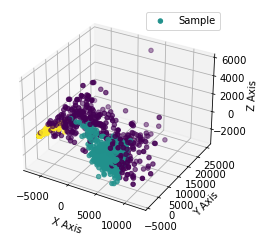

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced1[:, 0], reduced1[:, 1], reduced1[:, 2], c=labels, marker='o', label='Sample')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.legend()

plt.show()

It looks like there is good separation when trying to force the clustering into 2 classes (via PCA and setting a minimum size for the cluster), but upon closer inspection the classification accuracy is close to 50% signifying a random guess. So unsurprisingly, not only is 3 principal components too few, but demensionality reduction (and even combining all embeddings into a single vector) might not be helpful.

In [61]:
# Different attempt, this time by creating a similarity matrix using cosine distance

similarity_matrix = cosine_similarity(single_feature)
k = 2  
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(similarity_matrix)

pca = PCA(n_components=3)
reduced2 = pca.fit_transform(single_feature)

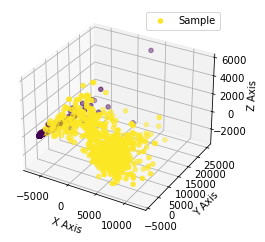

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced2[:, 0], reduced2[:, 1], reduced2[:, 2], c=cluster_labels, marker='o', label='Sample')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.legend()

plt.show()

A simplistic interpretation might lead to the conclusion that supervised methods are better at text classification tasks, especially with labelled data, as opposed to unsupervised methods which are better suited to EDA. However, the situation is much more complex than that. In this case, the dataset is small yet perfectly balanced in terms of class distribution. It is likely that accuracy figures would deteriorate if the class distribution was changed, making the dataset less balanced. In that sense, we can be confident that if the data had a very different distribution among its classes, results for the supervised model would fall. This means that supervised models, although very flexible and adaptable to different tasks, tend to get overfit easily. Unsupervised models theoretically are more resistant to this overfitting due to their independence from training data. Yet they also have drawbacks, especially for text datasets. For example, finding a meaningful distance function is difficult for text features, even after embedding them. 